In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.utils import class_weight
from sklearn.metrics import balanced_accuracy_score
from shapash.explainer.smart_explainer import SmartExplainer
import shap
%matplotlib inline

import xgboost as xgb
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import math

import time

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
 
import torchvision.transforms as transforms
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchinfo import summary

from livelossplot import PlotLosses
from matplotlib import pyplot

np.random.seed(0) 
torch.manual_seed(0)
import random
random.seed(0)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import dataset
CSV_FILE = "D2.DS_Occip.csv"
df=pd.read_csv(CSV_FILE)

# Check dataset

In [6]:
df.head()

,ID,Sex,Age,MMSE,CDR,Transition_Label,Transition,Class_Label,Class,original_shape_Elongation,...,lbp-3D-k_glszm_SmallAreaHighGrayLevelEmphasis,lbp-3D-k_glszm_SmallAreaLowGrayLevelEmphasis,lbp-3D-k_glszm_ZoneEntropy,lbp-3D-k_glszm_ZonePercentage,lbp-3D-k_glszm_ZoneVariance,lbp-3D-k_ngtdm_Busyness,lbp-3D-k_ngtdm_Coarseness,lbp-3D-k_ngtdm_Complexity,lbp-3D-k_ngtdm_Contrast,lbp-3D-k_ngtdm_Strength
0,006_S_0681,0,77.1,30,0.0,2,CN-CN,0,CN,0.251573,...,0.408171,0.408171,0.569885,0.169085,0.384364,0.096873,0.383809,0.180797,0.069286,0.379228
1,941_S_1203,1,83.4,30,0.0,2,CN-CN,0,CN,0.481976,...,0.547011,0.547011,0.444211,0.418004,0.158664,0.253489,0.166983,0.432479,0.258516,0.164945
2,011_S_0003,1,81.3,20,1.0,4,AD-AD,2,AD,0.548329,...,0.403769,0.494950,0.724160,0.271639,0.358783,0.413667,0.089915,0.536886,0.449457,0.082130
3,057_S_0779,1,79.6,28,0.0,0,CN-MCI,0,CN,0.451810,...,0.688124,0.688124,0.339157,0.202871,0.524000,0.221728,0.189221,0.259493,0.131204,0.181205
4,033_S_0920,0,80.1,30,0.0,2,CN-CN,0,CN,0.279128,...,0.585296,0.585296,0.401928,0.121231,0.493612,0.058429,0.516466,0.107663,0.031873,0.518927


<AxesSubplot:xlabel='Age'>

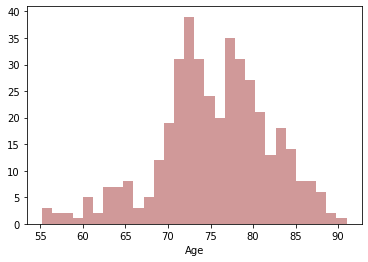

In [7]:
sns.distplot(df['Age'],kde=False,color='darkred',bins=30)

<AxesSubplot:>

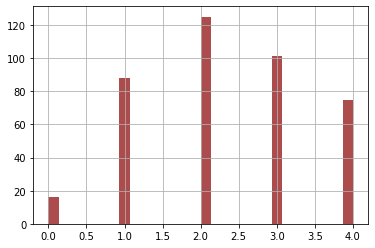

In [8]:
df['Transition_Label'].hist(bins=30,color='darkred',alpha=0.7)
#"CN-MCI":0, "MCI-AD":1, "CN-CN":2, "MCI-MCI":3

<AxesSubplot:xlabel='Transition_Label', ylabel='Age'>

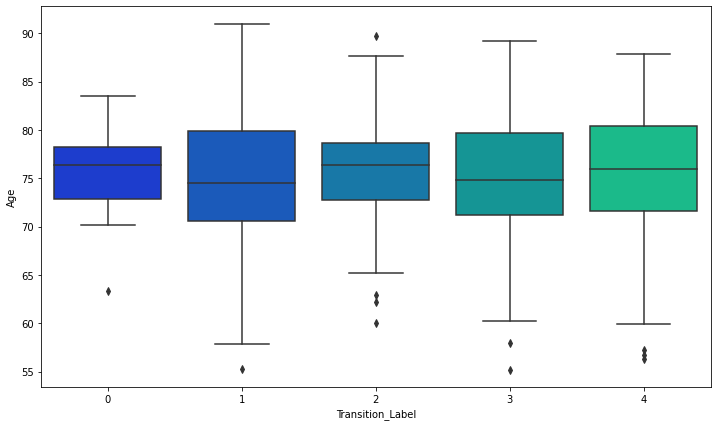

In [9]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Transition_Label',y='Age',data=df,palette='winter')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Columns: 2028 entries, ID to lbp-3D-k_ngtdm_Strength
dtypes: float64(2021), int64(4), object(3)
memory usage: 6.3+ MB


In [11]:
df.describe()

,Sex,Age,MMSE,CDR,Transition_Label,Class_Label,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,...,lbp-3D-k_glszm_SmallAreaHighGrayLevelEmphasis,lbp-3D-k_glszm_SmallAreaLowGrayLevelEmphasis,lbp-3D-k_glszm_ZoneEntropy,lbp-3D-k_glszm_ZonePercentage,lbp-3D-k_glszm_ZoneVariance,lbp-3D-k_ngtdm_Busyness,lbp-3D-k_ngtdm_Coarseness,lbp-3D-k_ngtdm_Complexity,lbp-3D-k_ngtdm_Contrast,lbp-3D-k_ngtdm_Strength
count,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,...,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000
mean,0.555556,75.415802,27.125926,0.377778,2.323457,0.837037,0.389359,0.677440,0.570675,0.273855,...,0.531332,0.536849,0.458686,0.265893,0.347456,0.203077,0.259776,0.309923,0.171074,0.258200
std,0.497519,6.524493,2.598828,0.313476,1.124246,0.712763,0.145657,0.105930,0.150340,0.097121,...,0.168350,0.169718,0.179825,0.104355,0.154991,0.118673,0.145818,0.152116,0.140882,0.144414
min,0.000000,55.200000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,71.700000,25.000000,0.000000,1.000000,0.000000,0.282039,0.616269,0.465403,0.211189,...,0.429221,0.438712,0.339157,0.201340,0.242179,0.124288,0.156602,0.206808,0.083497,0.157300
50%,1.000000,75.600000,28.000000,0.500000,2.000000,1.000000,0.380470,0.689762,0.587583,0.267523,...,0.534596,0.537737,0.452369,0.260269,0.323718,0.181054,0.229308,0.286973,0.137040,0.229654
75%,1.000000,79.800000,29.000000,0.500000,3.000000,1.000000,0.487788,0.748680,0.674378,0.329050,...,0.648843,0.655725,0.577132,0.320601,0.411318,0.266383,0.320091,0.378833,0.211885,0.316861
max,1.000000,91.000000,30.000000,1.000000,4.000000,2.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Preparing the dataset

In [3]:
#Declare feature vector and target variable

dtypes = df.dtypes.to_dict()

print(df.shape)

for col_nam, typ in dtypes.items():
    if "Unnamed" in col_nam:
        df.drop(col_nam, axis = 1,inplace = True)
        
df.drop("Age",axis=1,inplace=True)
df.drop("MMSE",axis=1,inplace=True)
df.drop("CDR",axis=1,inplace=True)
df.drop("Transition",axis=1,inplace=True)
df.drop("Class_Label",axis=1,inplace=True)
df.drop("Class",axis=1,inplace=True)

print(df.shape)

y=df['Transition_Label']

df.drop("ID", axis = 1,inplace = True)
df.drop("Transition_Label", axis = 1,inplace = True)

print(df.shape)

X=df 

(405, 2028)
(405, 2022)
(405, 2020)


In [4]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [5]:
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb


model = xgb.XGBClassifier(colsample_bytree=1.0, gamma=0.2,
                                      learning_rate=0.001,
                                      max_depth=5,
                                      min_child_weight=3,
                                      n_estimators=1000, n_jobs=12,
                                      objective='multi:softprob',
                                      reg_alpha=0.1, reg_lambda=1.0, 
                                      subsample=1.0)

kfold = KFold(n_splits=10, random_state=42, shuffle=True)

scores = cross_val_score(model, X, np.ravel(y), cv=kfold)
scores

[11:06:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:26:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:46:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:05:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

array([0.43902439, 0.26829268, 0.12195122, 0.3902439 , 0.31707317,
       0.35      , 0.2       , 0.125     , 0.25      , 0.275     ])

In [6]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.27 accuracy with a standard deviation of 0.10


In [7]:
import numpy as np
import copy as cp
import matplotlib.pyplot as plt

import seaborn as sns
from typing import Tuple
from sklearn.metrics import confusion_matrix

#confusion_matrix

def cross_val_predict(model, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array, np.array]:

    model_ = cp.deepcopy(model)
    
    no_classes = len(np.unique(y))
    
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes]) 

    for train_ndx, test_ndx in kfold.split(X):

        train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]

        actual_classes = np.append(actual_classes, test_y)

        model_.fit(train_X, train_y)
        predicted_classes = np.append(predicted_classes, model_.predict(test_X))

        try:
            predicted_proba = np.append(predicted_proba, model_.predict_proba(test_X), axis=0)
        except:
            predicted_proba = np.append(predicted_proba, np.zeros((len(test_X), no_classes), dtype=float), axis=0)

    return actual_classes, predicted_classes, predicted_proba


In [8]:
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    
    plt.figure(figsize=(12.8,6))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

    plt.show()

[14:23:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:43:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:03:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:23:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

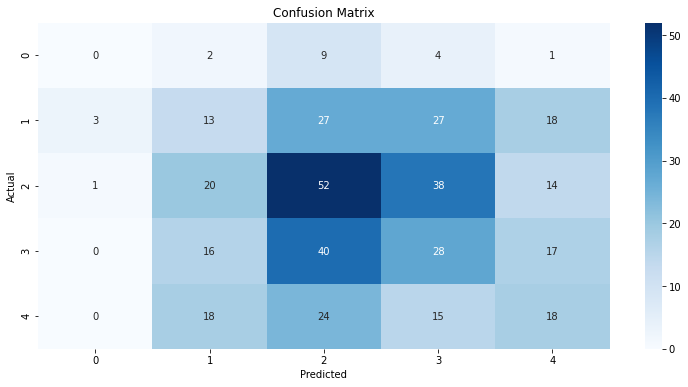

In [9]:
actual_classes, predicted_classes, _ = cross_val_predict(model, kfold, X.to_numpy(), y.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, [0, 1, 2, 3, 4])

In [14]:
#Shap 
clf_xgb = model.fit(X,y)
explainer = shap.Explainer(clf_xgb)
shap_values = explainer.shap_values(X)
shap_obj=explainer(X)
shap.plots.beeswarm(shap_obj)

[23:03:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


ValueError: The beeswarm plot does not support plotting explanations with instances that have more than one dimension!

[22:43:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


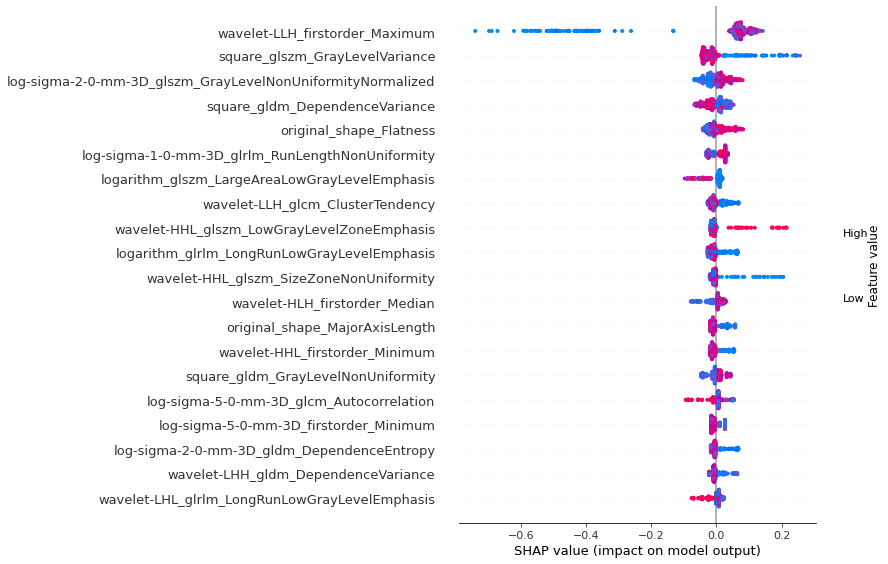

In [13]:
#Shap Values1
clf_xgb = model.fit(X,y)
explainer = shap.Explainer(clf_xgb)
shap_values = explainer.shap_values(X)
shap_obj=explainer(X)
#shap.plots.beeswarm(shap_obj)
shap.summary_plot(shap_values[1],X)

[17:26:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


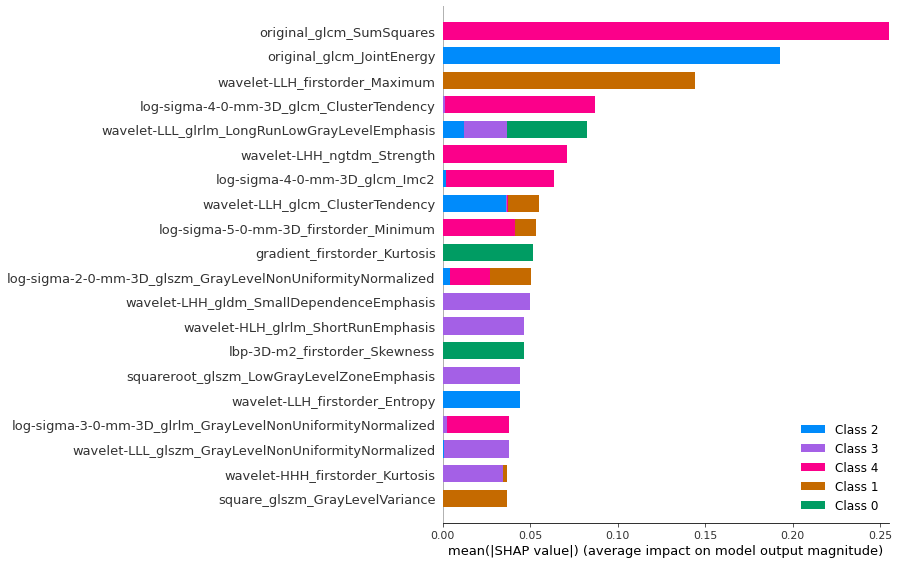

In [10]:
#Shap Values
clf_xgb = model.fit(X,y)
explainer = shap.Explainer(clf_xgb)
shap_values = explainer.shap_values(X)
shap_obj=explainer(X)
#shap.plots.beeswarm(shap_obj)
shap.summary_plot(shap_values,X)

Feature Importances :  [0.         0.00176794 0.00177428 ... 0.         0.         0.        ]


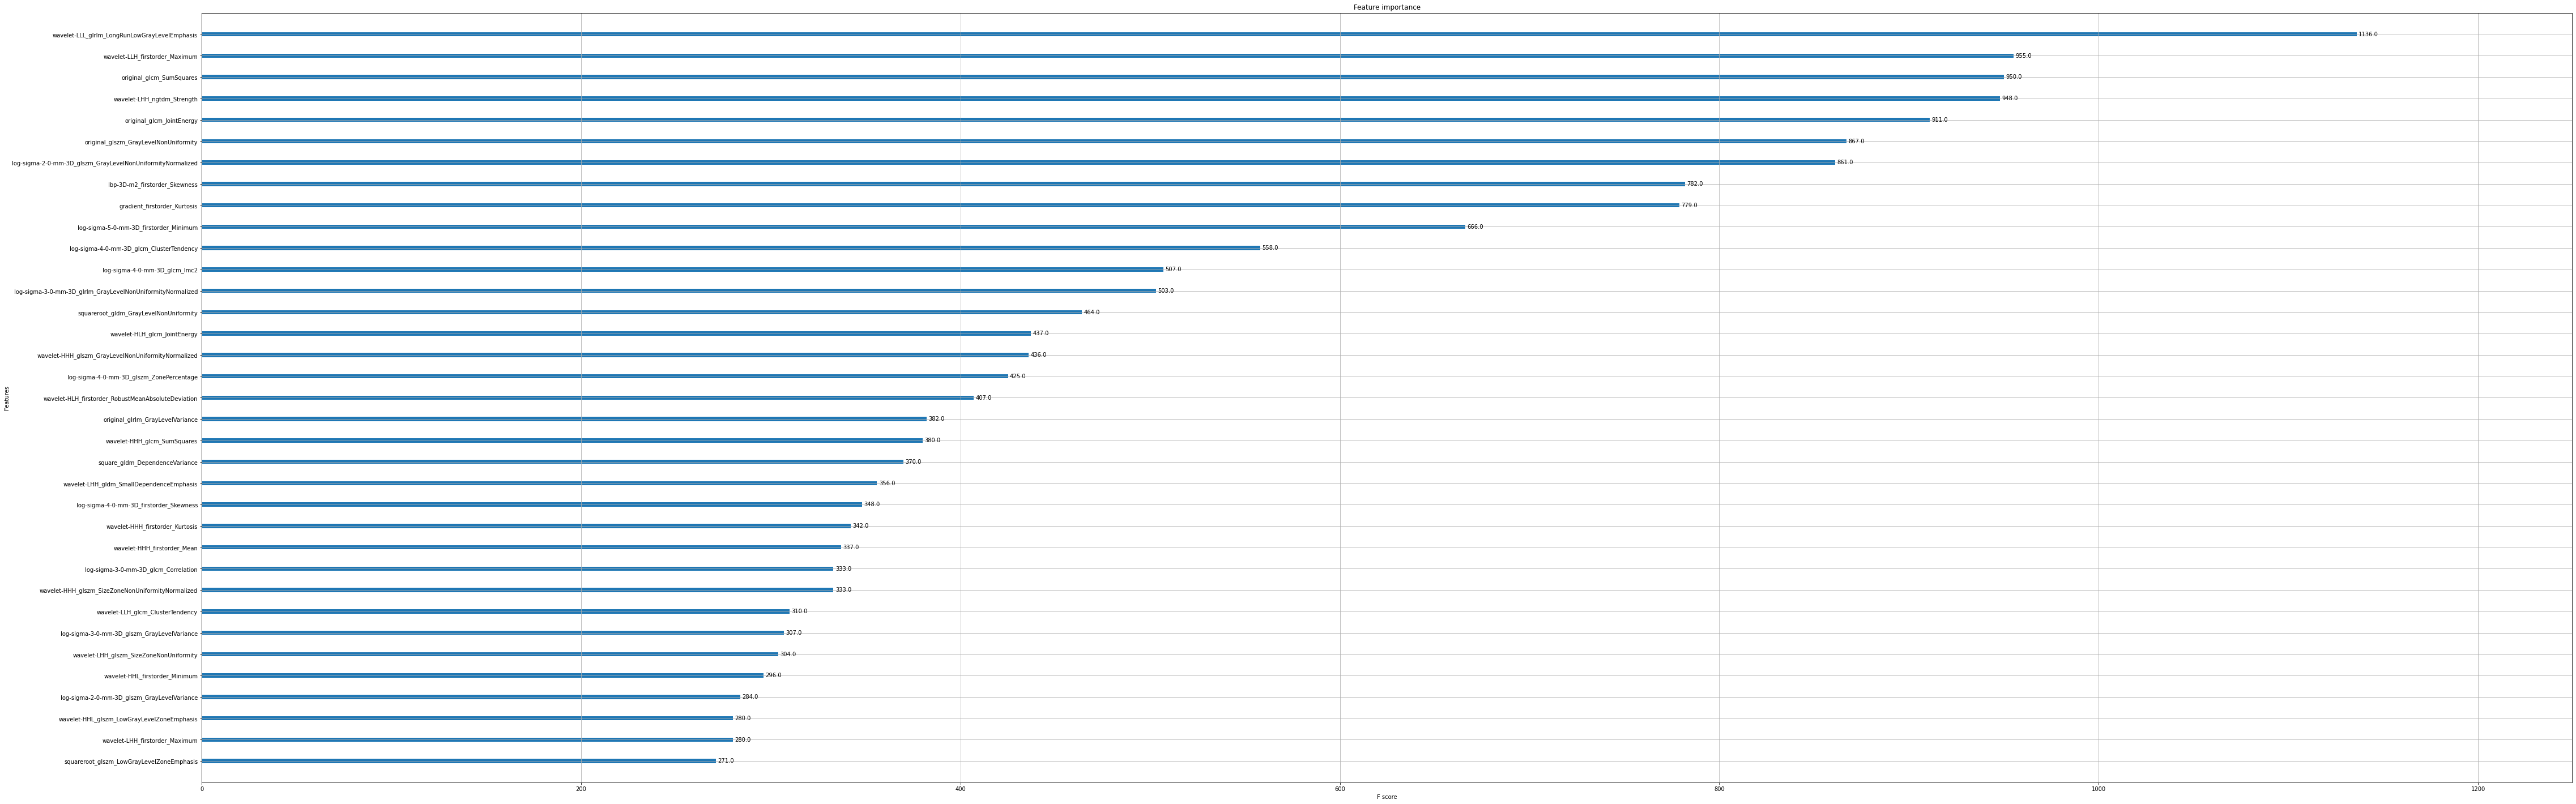

In [12]:
#Feature Importance
from matplotlib import pyplot
from xgboost import plot_importance

print("Feature Importances : ", clf_xgb.feature_importances_)

plot_importance(clf_xgb, max_num_features=35)
plt.rcParams["figure.figsize"] = (75,25)
plt.show()